In [180]:
import sys
sys.path.append("../")

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *
from utils.utils import ring2nest

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [154]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Test embedding net

In [155]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [156]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.reorder(hp.ud_grade(hp_mask_nside1, nside), r2n=True)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

hp_mask_nside1 = hp.reorder(hp_mask_nside1, r2n=True)

In [157]:
hp_mask_nside1_ring = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0, mask_ring = True, inner = 0, outer = 25)
roi_sim_ring = hp.ud_grade(hp_mask_nside1_ring, 128)

In [158]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask = hp.reorder(hp_mask, r2n=True)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [159]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Test data generation

In [160]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [161]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [162]:
from simulations.wrapper import simulator

In [163]:
import sys
from sbi import utils
from sbi import inference

In [164]:
from utils.templates import get_NFW2_template

In [165]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)

temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

temp_mA_pibrem /= np.mean(temp_mA_pibrem[~roi_normalize_temps] )
temp_mA_ics /= np.mean(temp_mA_ics[~roi_normalize_temps] )


ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
# ps_mask = np.load("../data/fermi_data/fermidata_pscmask.npy") > 0

roi_mask = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask), r2n=True)
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)

In [140]:
def get_signal_injection(coeff, plot_map=False, mask=hp_mask):
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce), r2n=True)
    in_map[mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

def get_signal_injection_ps(coeff, plot_map=False, mask=hp_mask, ps="medium"):
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy"), r2n=True)
    in_map[mask] = 0
    
    if ps == "bright":
        sb1 = 20.
    elif ps == "medium":
        sb1 = 10.
    elif ps == "dim":
        sb1 = 5.
    
    if coeff != 0.:
        
        prior_ps = [[0, coeff * 1., 20.0, 1.9, -10.0, sb1, 1.], [0, coeff * 1., 20.0, 1.9, -9.99, sb1, 1.]]
        prior_ps = utils.BoxUniform(low=torch.tensor(prior_ps[0]), high=torch.tensor(prior_ps[1]))
        theta = prior_ps.sample((1,))[0]
        temps_ps_sim = [temp_gce]
        temps_poiss_sim = [temp_gce]
        
        ps_map = simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, hp.reorder(masks_list[0], n2r=True)
                      , hp.reorder(roi_mask_norm, n2r=True), hp.reorder(roi_mask, n2r=True), pc_inst.psf_r_func, fermi_exp)[0]
        
        ps_map = ring2nest(ps_map, roi_sim_ring)
    
    else:
        ps_map = np.zeros((~masks_list[0]).sum())
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)
    
    in_map = in_map[~masks_list[0]]
    in_map += ps_map[0]
    
    in_map = torch.Tensor(in_map)
    
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

## SNPE


In [61]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, fc_dims=None).to(device)

In [62]:
sg_embed(get_signal_injection(0.).unsqueeze(0),).shape

torch.Size([1, 258])

In [63]:
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [65]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 0.001], [1.5, 1.5, 1.5, 12., 5.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2.5, 20.0, 1.99, 1.99, 40.0, 4.99, 2.5, 20.0, 1.99, 1.99, 40.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

In [66]:
from sbi import utils as utils

In [67]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device.type)

In [68]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [69]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/Brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics], r2n=True)
temps_ps = hp.reorder([temp_gce, temp_dsk], r2n=True)

In [70]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce, temp_dsk]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [71]:
roi_normalize = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25), r2n=True)

In [72]:
from sbi.utils import x_shape_from_simulation

In [169]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = 'fde670dde7a948e0a76127d0f22ca51b'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns/1/' + run_id + '/artifacts/density_estimator')

In [170]:
from utils.plotting import make_plot, make_signal_injection_plot
roi_sim = masks_list[0]

### Analysis on simulations

In [208]:
n_samples = 10000

In [209]:
# data_map = torch.Tensor(ring2nest(np.load("../data/samples/x_ModelO_DM_only.npy")[:5, 0, :], roi_sim_ring))
# aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[:5]
# thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[:5]
# x_presimulated = torch.Tensor(data_map).unsqueeze(1)
# x_aux_presimulated = torch.Tensor(aux)
# theta_presimulated = (thetas)

# inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
# posterior = inference_inst.build_posterior(density_estimator)

# x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
# theta_test = theta_presimulated

# roi_mask_reduced = hp.reorder(cm.make_mask_total(nside=128, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=15, custom_mask=ps_mask), r2n=True)

# indices_mask_reduced = np.intersect1d(np.where(~masks_list[0] == 1), np.where(~roi_mask_reduced == 1), return_indices=True)[1]

# a = indices_mask_reduced
# b = np.arange(np.sum(~masks_list[0] == 1))
# c = torch.Tensor(np.setdiff1d(np.union1d(a, b), np.intersect1d(a, b))).type(torch.int64)

# data_map[:, c] = 0.

# the_map = np.zeros(hp.nside2npix(128))
# the_map[~masks_list[0]] = data_map[0]

# hp.mollview(the_map, nest=True)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$8.2^{0.2}_{0.6}\%$ & $13.3^{3.7}_{6.7}\%$ & $2.6^{1.1}_{2.4}$ & $5.2^{0.4}_{1.1}\%$ & $2.5^{1.0}_{2.1}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$8.1^{0.2}_{0.6}\%$ & $13.2^{5.3}_{8.1}\%$ & $2.5^{1.0}_{2.3}$ & $5.5^{0.4}_{1.0}\%$ & $4.3^{1.0}_{2.7}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$8.5^{0.2}_{0.6}\%$ & $6.9^{2.7}_{4.1}\%$ & $2.5^{1.0}_{2.3}$ & $5.7^{0.5}_{1.1}\%$ & $2.6^{1.1}_{2.3}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$7.6^{0.2}_{0.6}\%$ & $7.1^{2.1}_{4.0}\%$ & $2.6^{1.1}_{2.4}$ & $5.1^{0.5}_{1.1}\%$ & $1.1^{0.9}_{0.9}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$8.5^{0.2}_{0.6}\%$ & $16.1^{4.9}_{8.7}\%$ & $2.8^{0.9}_{2.7}$ & $4.6^{0.4}_{1.0}\%$ & $3.5^{1.1}_{2.6}$


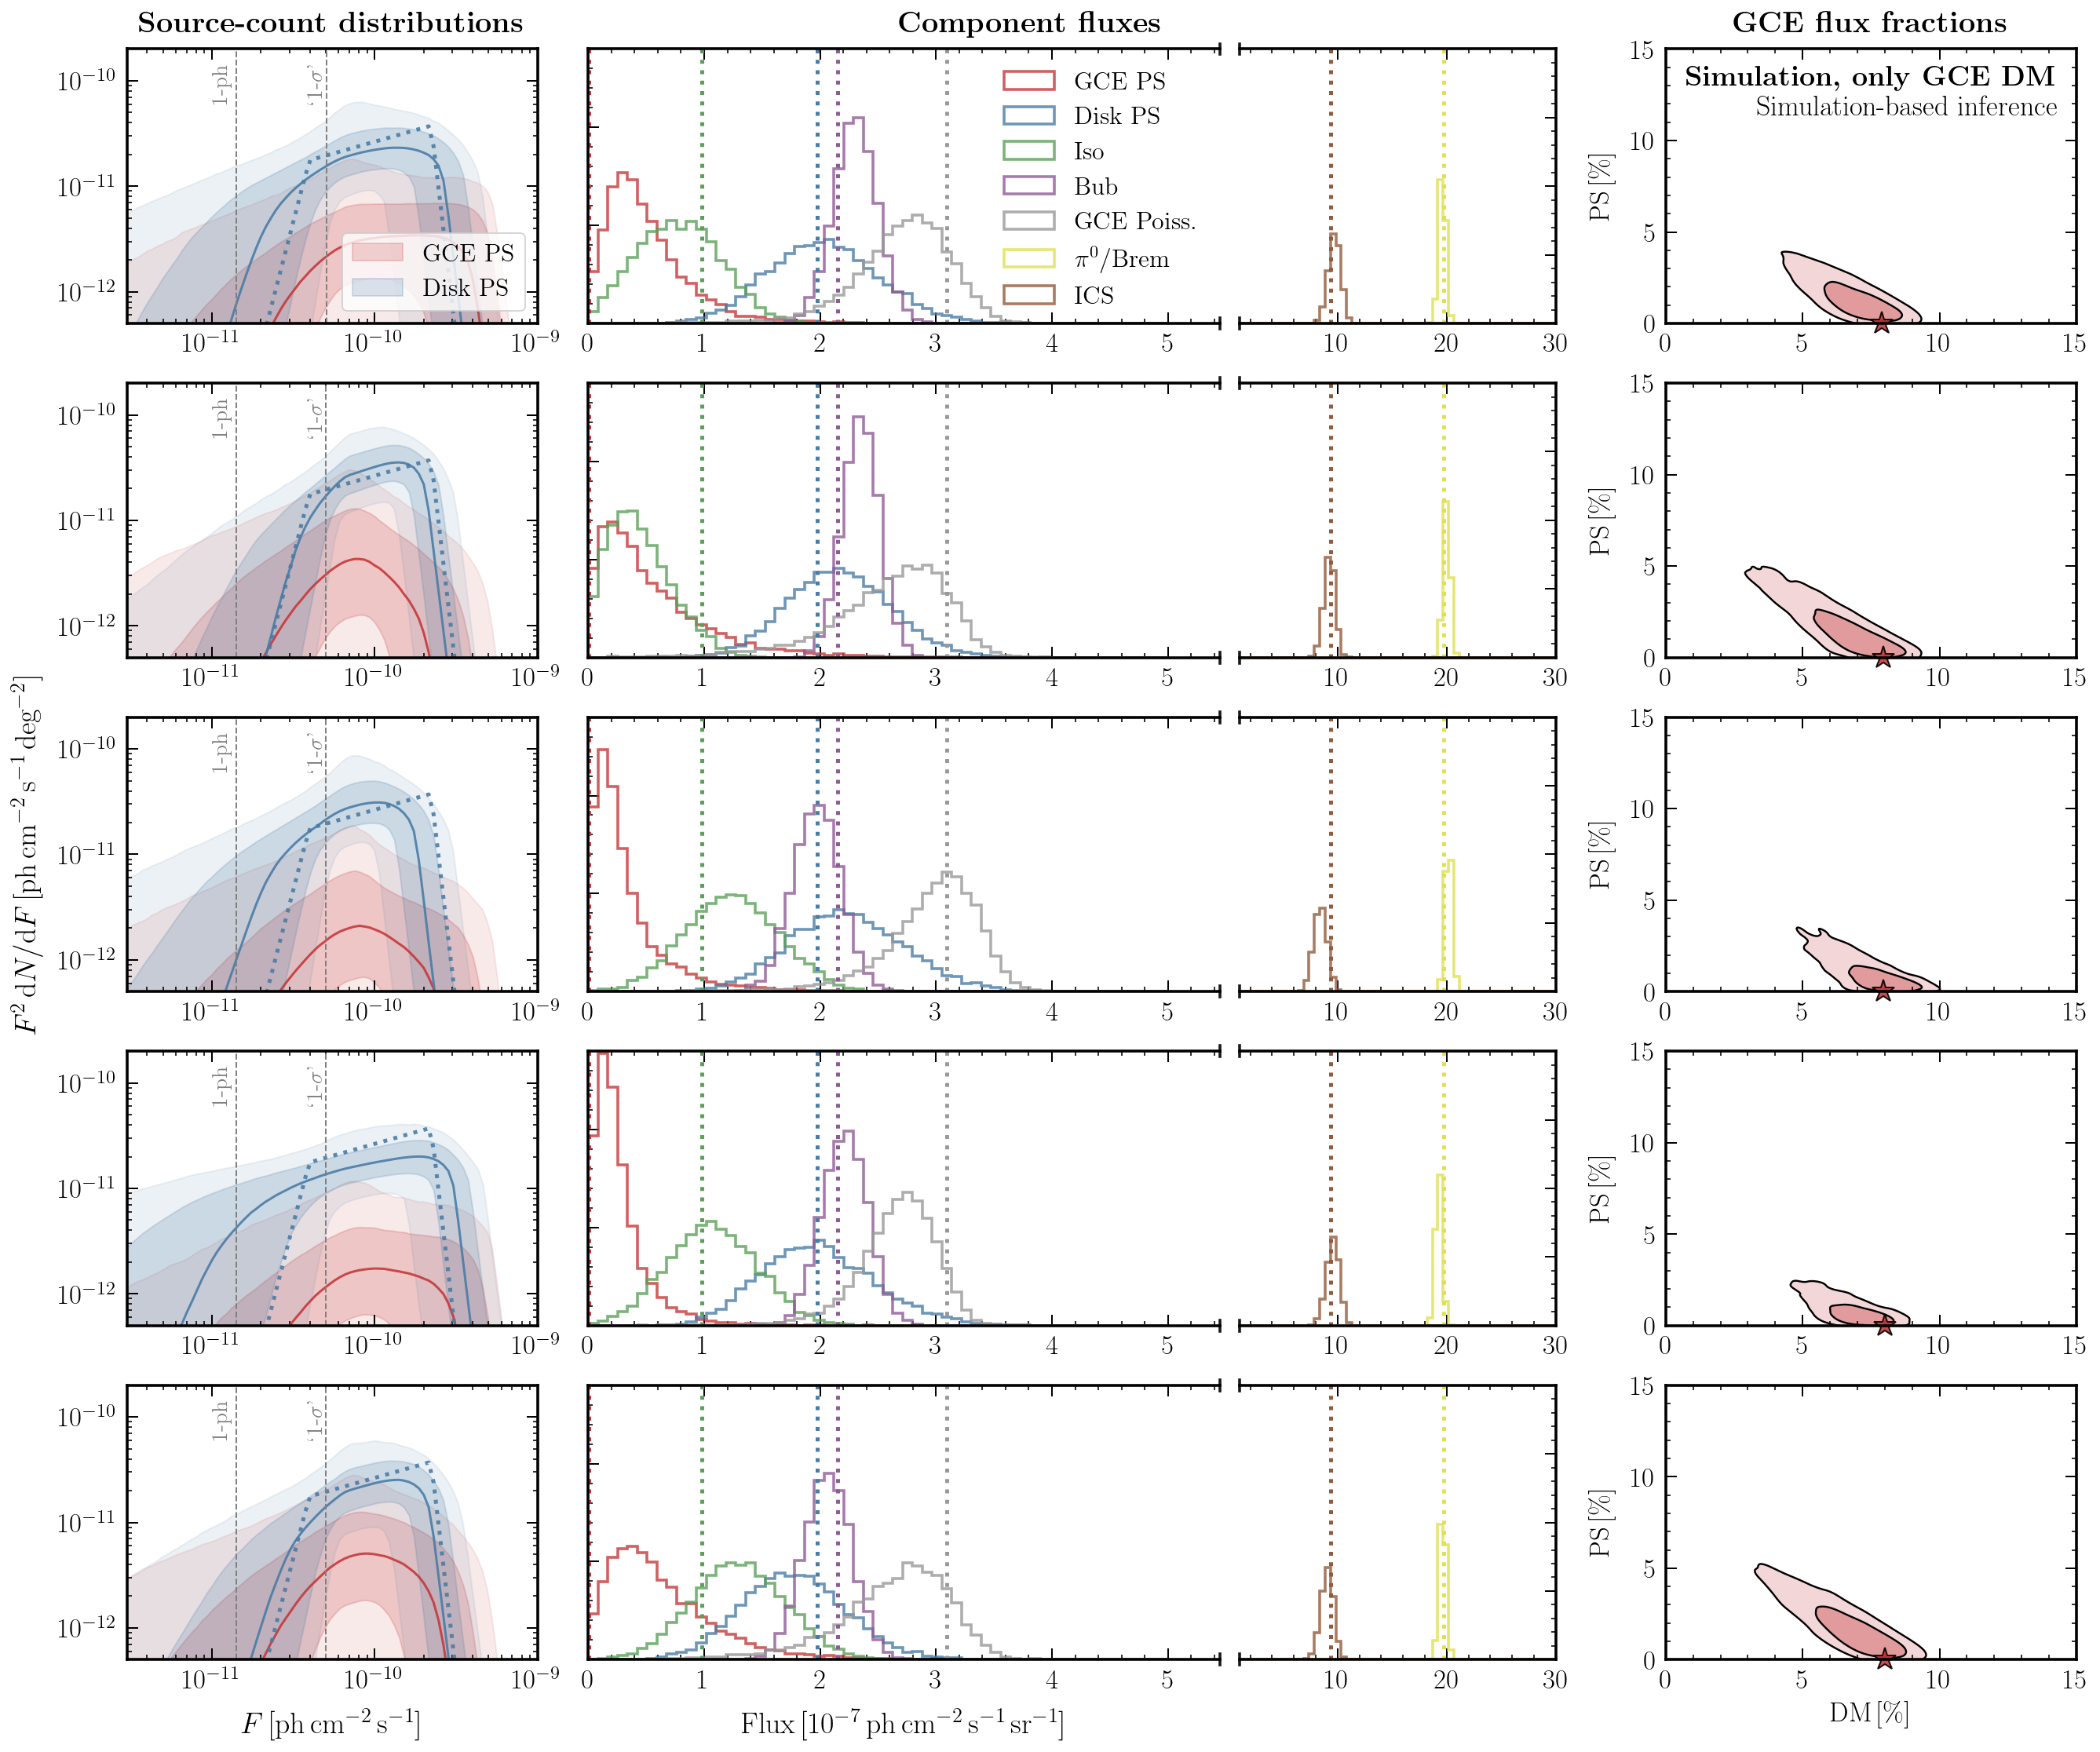

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [215]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_only.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 4 / 1.3 * 5), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_dm.pdf", sub1=r"\bf{Simulation, only GCE DM}", sub2=r"Simulation-based inference") 


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$7.7^{0.3}_{0.7}\%$ & $85.4^{3.6}_{10.8}\%$ & $4.3^{0.6}_{2.2}$ & $8.4^{0.5}_{1.4}\%$ & $3.7^{0.9}_{2.6}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$7.6^{0.3}_{0.7}\%$ & $82.3^{4.4}_{13.6}\%$ & $4.0^{0.9}_{2.5}$ & $6.9^{0.5}_{1.3}\%$ & $3.7^{0.9}_{2.5}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$9.5^{0.3}_{0.7}\%$ & $81.4^{4.7}_{14.1}\%$ & $3.5^{1.1}_{2.4}$ & $6.0^{0.5}_{1.3}\%$ & $3.3^{1.1}_{2.6}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$7.6^{0.3}_{0.7}\%$ & $89.9^{2.4}_{7.0}\%$ & $5.0^{0.7}_{1.7}$ & $5.2^{0.5}_{1.2}\%$ & $4.0^{0.9}_{2.6}$


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$8.4^{0.3}_{0.7}\%$ & $76.2^{4.7}_{13.4}\%$ & $4.0^{0.9}_{2.6}$ & $5.1^{0.5}_{1.2}\%$ & $3.7^{0.9}_{2.8}$


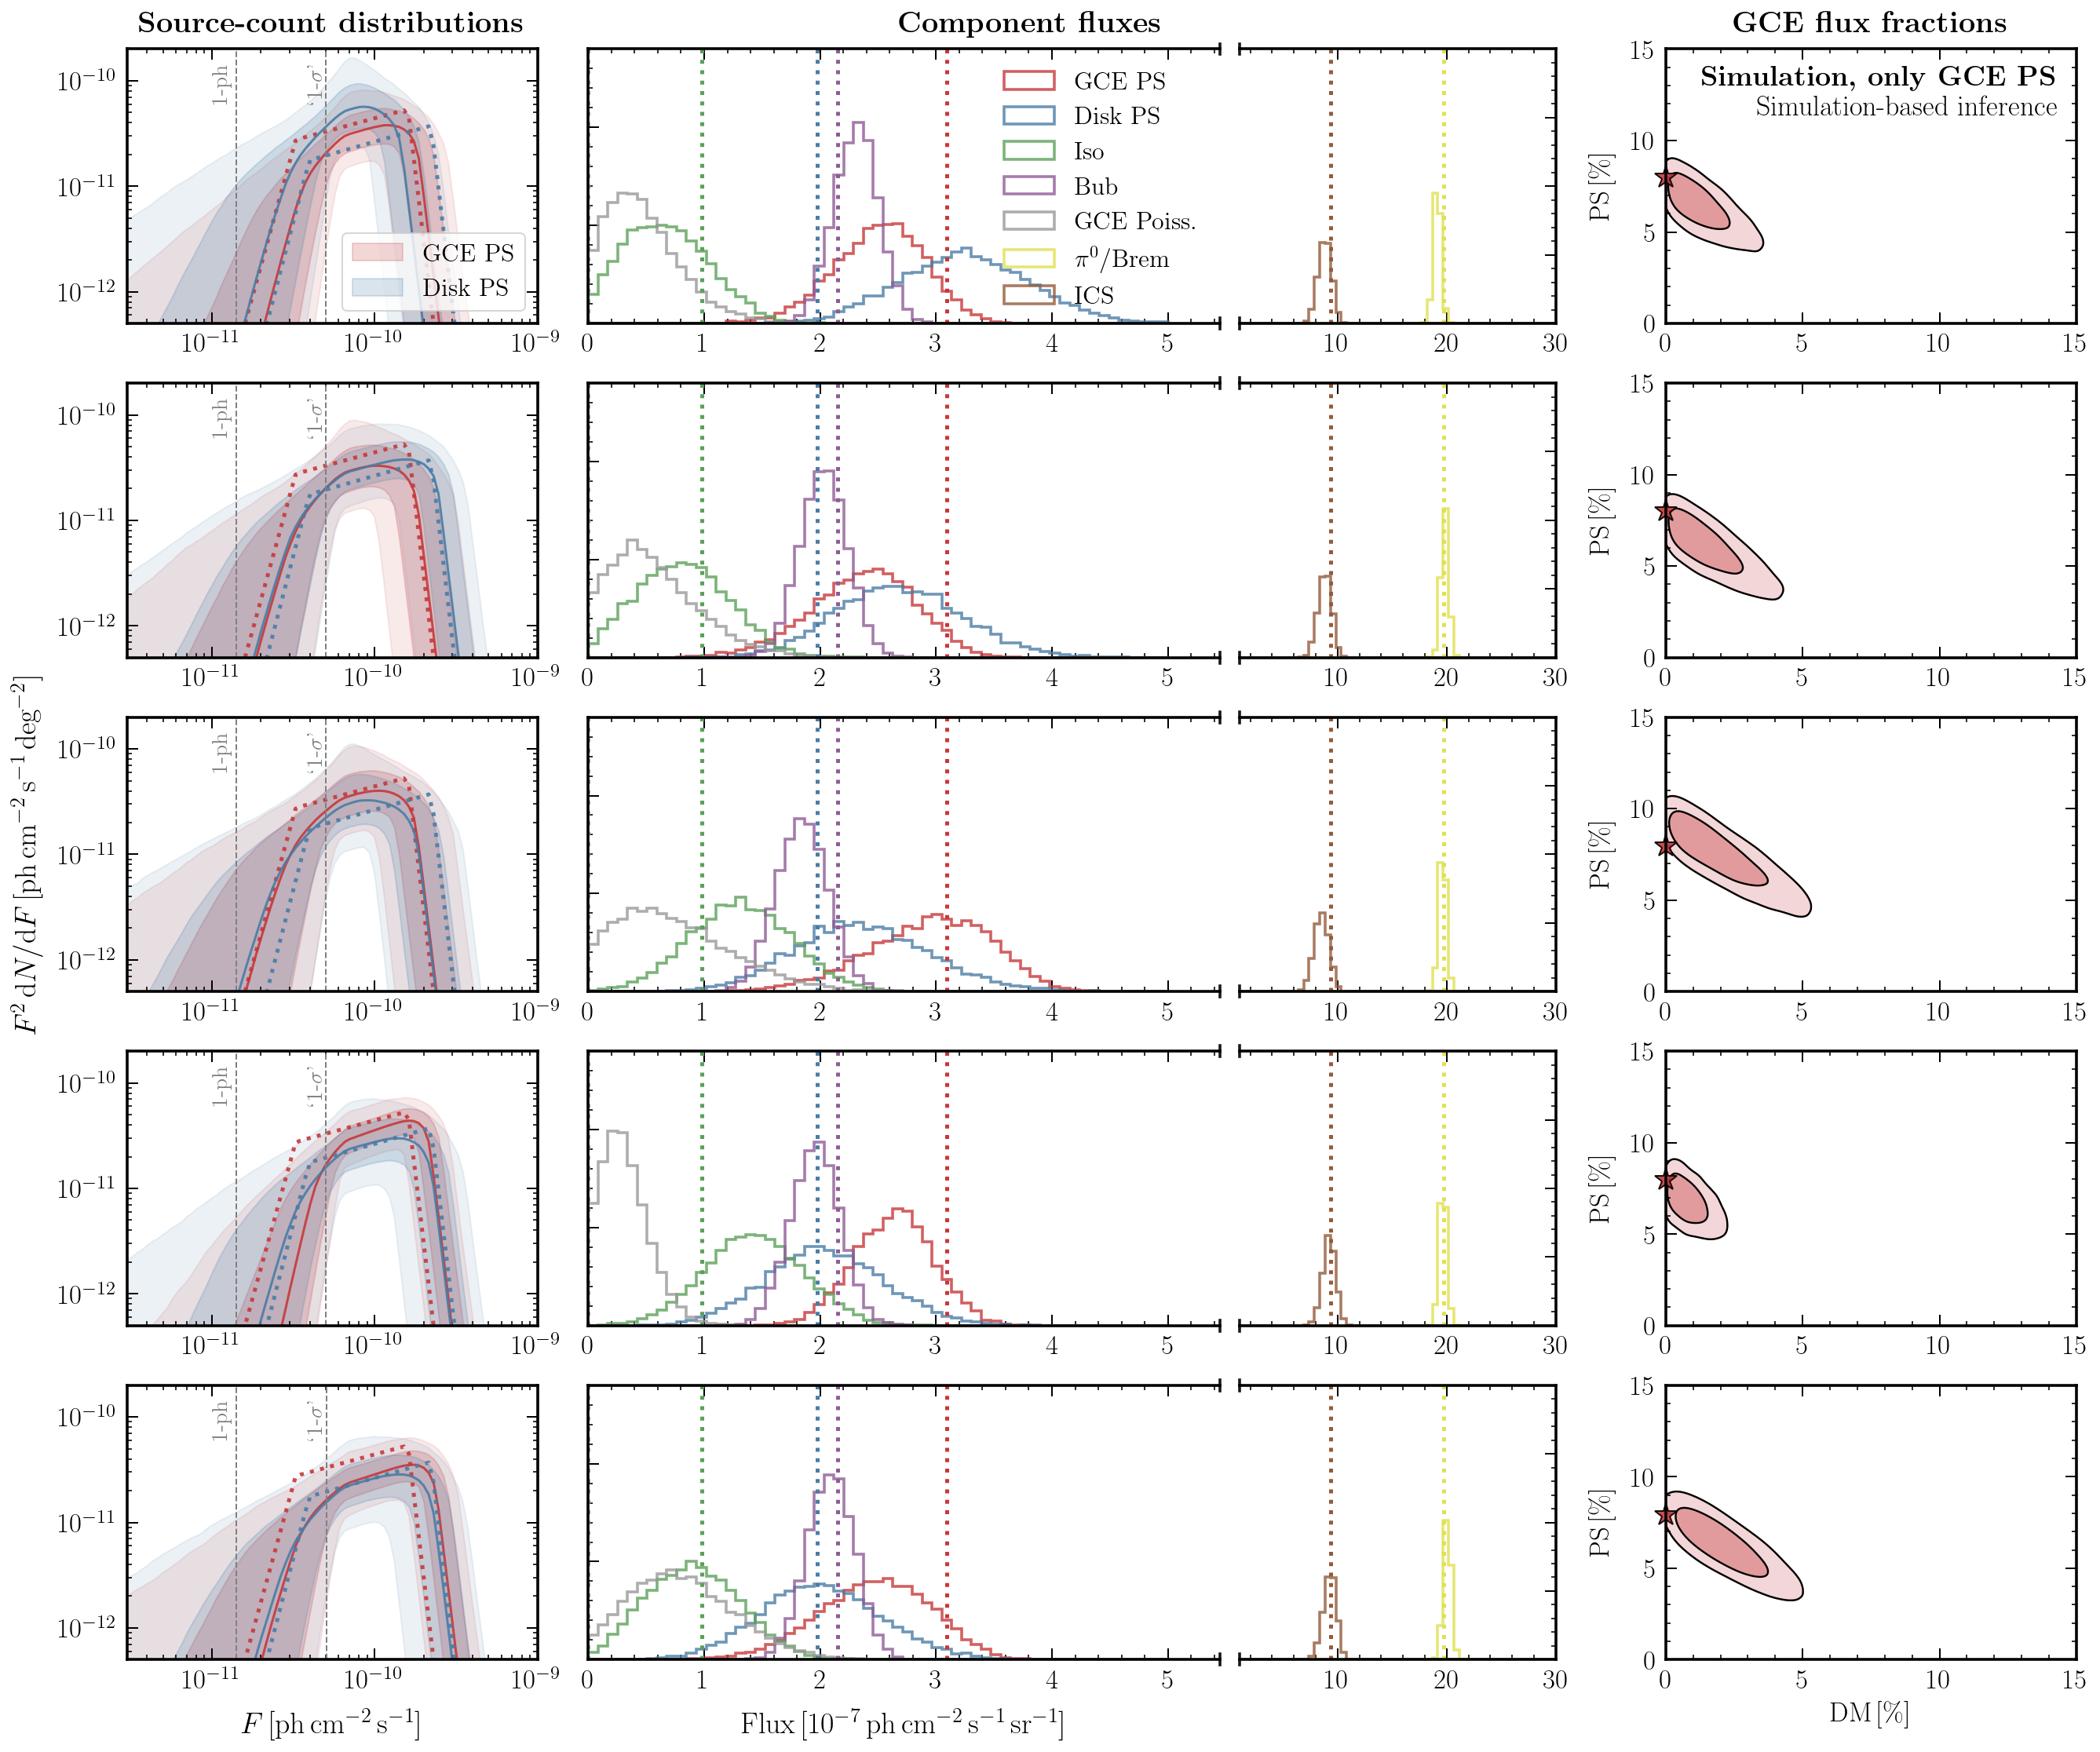

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [216]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_PS_only.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_PS_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_PS_only.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 4. / 1.3 * 5), n_samples=n_samples, \
          temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_ps.pdf", sub1=r"\bf{Simulation, only GCE PS}", sub2=r"Simulation-based inference") 

### Analysis on data

In [173]:
roi_mask_reduced = hp.reorder(cm.make_mask_total(nside=128, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, 
                                                 outer=25, custom_mask=ps_mask), r2n=True)

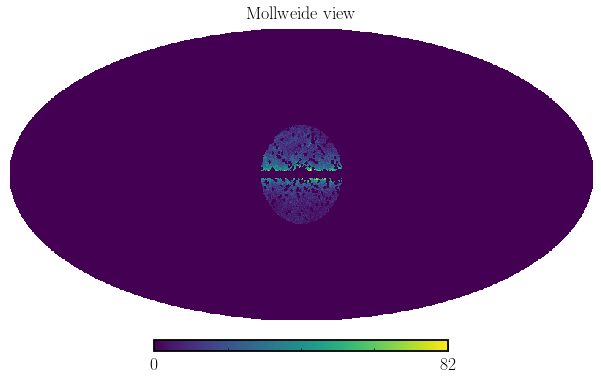

In [174]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection(coeff, mask=hp_mask).detach().numpy() for coeff in coeff_ary]))

data_map = x_test[:, 0, :-2]
aux = x_test[:, :, -2:]

indices_mask_reduced = np.intersect1d(np.where(~masks_list[0] == 1), np.where(~roi_mask_reduced == 1), return_indices=True)[1]

a = indices_mask_reduced
b = np.arange(np.sum(~masks_list[0] == 1))
c = torch.Tensor(np.setdiff1d(np.union1d(a, b), np.intersect1d(a, b))).type(torch.int64)

data_map[:, c] = 0.

the_map = np.zeros(hp.nside2npix(128))
the_map[~masks_list[0]] = data_map[0]

hp.mollview(the_map, nest=True)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$7.7^{0.2}_{0.6}\%$ & $30.0^{8.6}_{17.1}\%$ & $2.1^{1.1}_{2.0}$ & $5.1^{0.5}_{1.1}\%$ & $3.5^{1.1}_{2.5}$


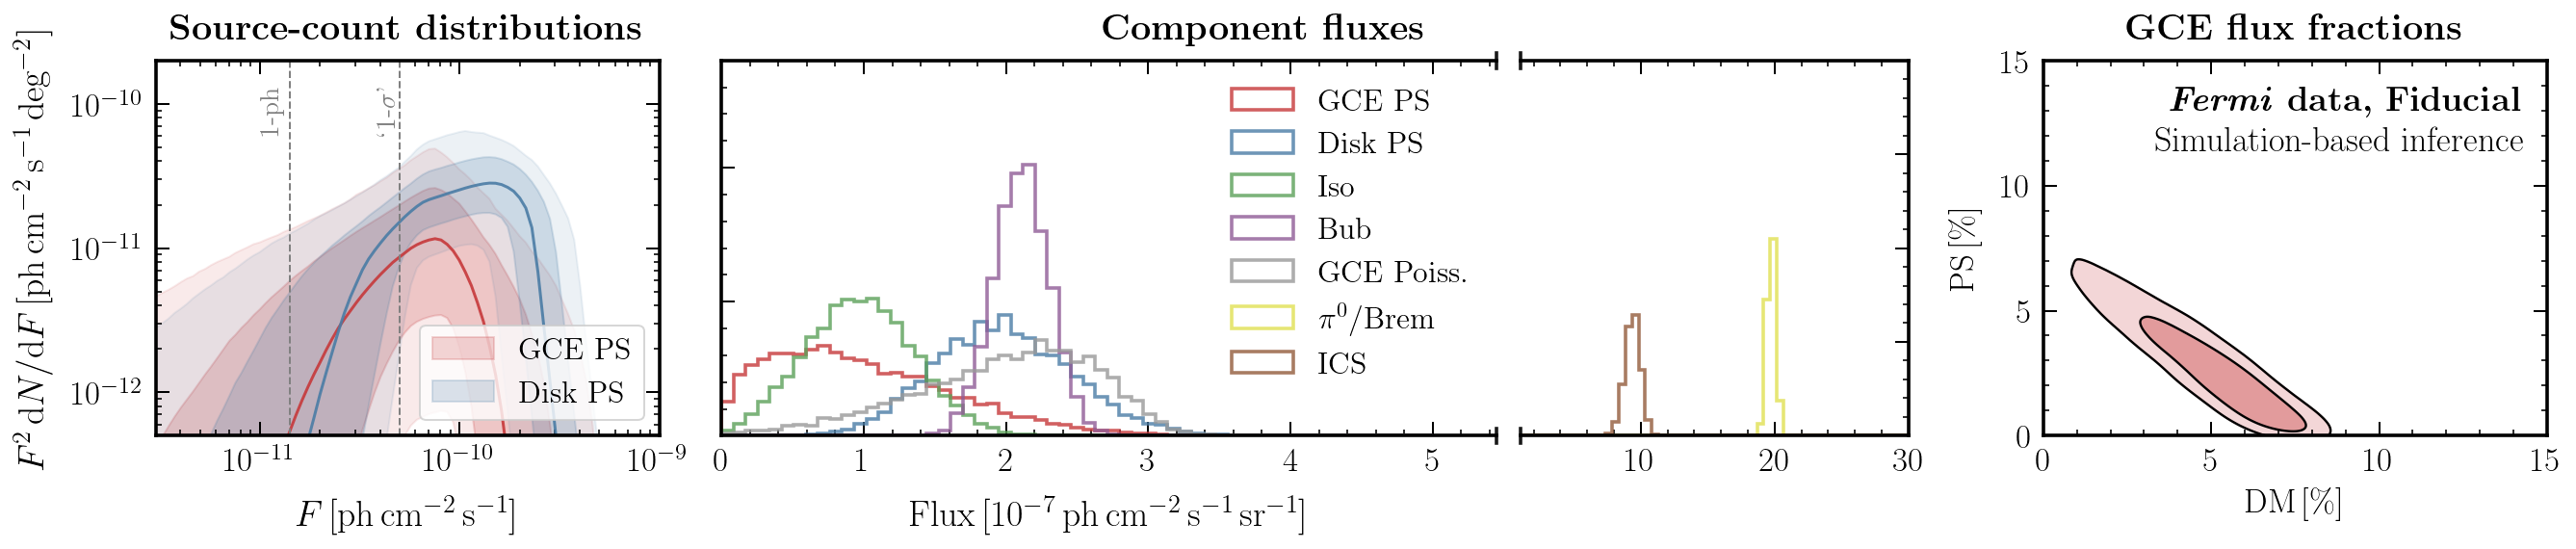

<Figure size 432x324 with 0 Axes>

In [207]:
x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)

posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, \
          signal_injection=True, figsize=(24 / 1.3, 5 / 1.3), save_filename="../paper/plots/data_fid_sbi.pdf", n_samples=n_samples, temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Fiducial}", sub2=r"Simulation-based inference")



In [97]:
data_samples.mean(axis=0)

tensor([ 0.9286,  0.4314,  0.8864,  0.7524,  7.8482,  3.7519,  0.4267, 14.8363,
         1.5499, -3.5068, 12.0333,  2.3526,  0.9118, 15.0171,  1.5408, -4.5344,
        15.4356,  2.8705], grad_fn=<MeanBackward1>)

### Signal injection on data

#### DM signal injection


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


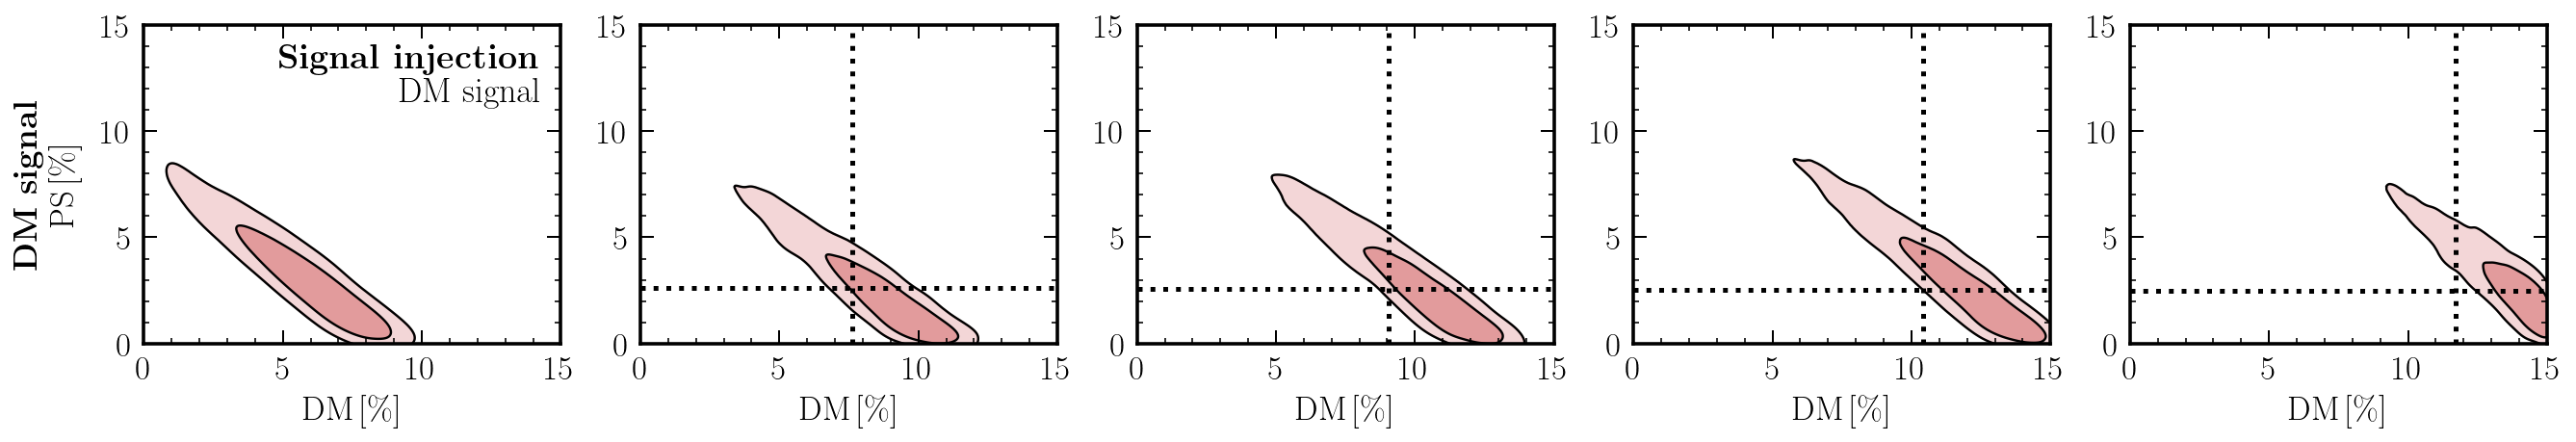

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [219]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy() for coeff in coeff_ary]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)

make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, signal_injection="dm", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_dm.pdf", sub1=r"\bf{Signal injection}", sub2="DM signal")

#### PS signal injection

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


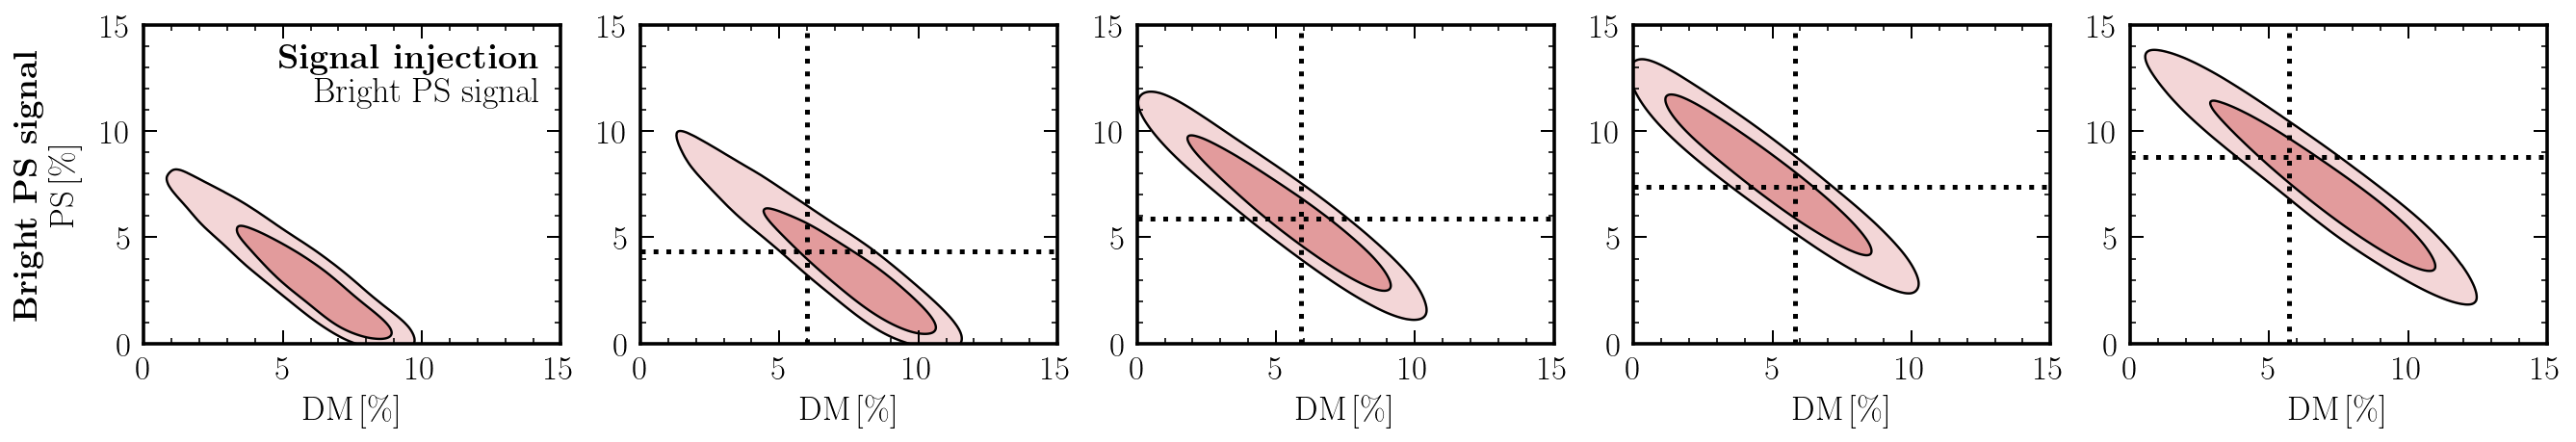

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [220]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection_ps(coeff, ps='bright').detach().numpy() for coeff in tqdm_notebook(coeff_ary)]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)
make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, \
                           signal_injection="ps", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_ps.pdf", sub1=r"\bf{Signal injection}", sub2="Bright PS signal")

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


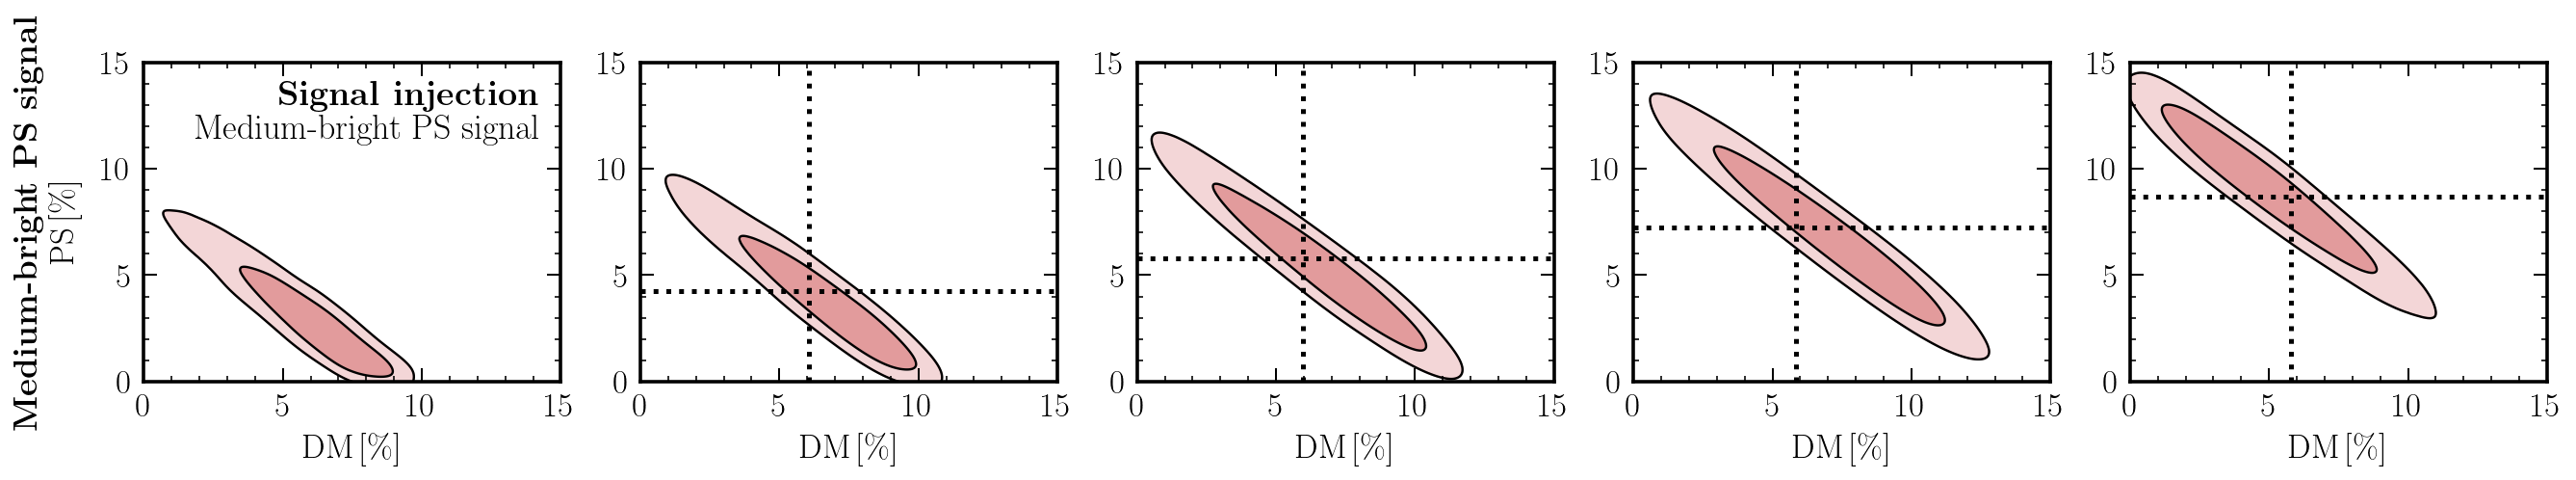

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [221]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection_ps(coeff, ps='medium').detach().numpy() for coeff in tqdm_notebook(coeff_ary)]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)
make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, signal_injection="ps", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_med_ps.pdf", sub1=r"\bf{Signal injection}", sub2="Medium-bright PS signal")

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


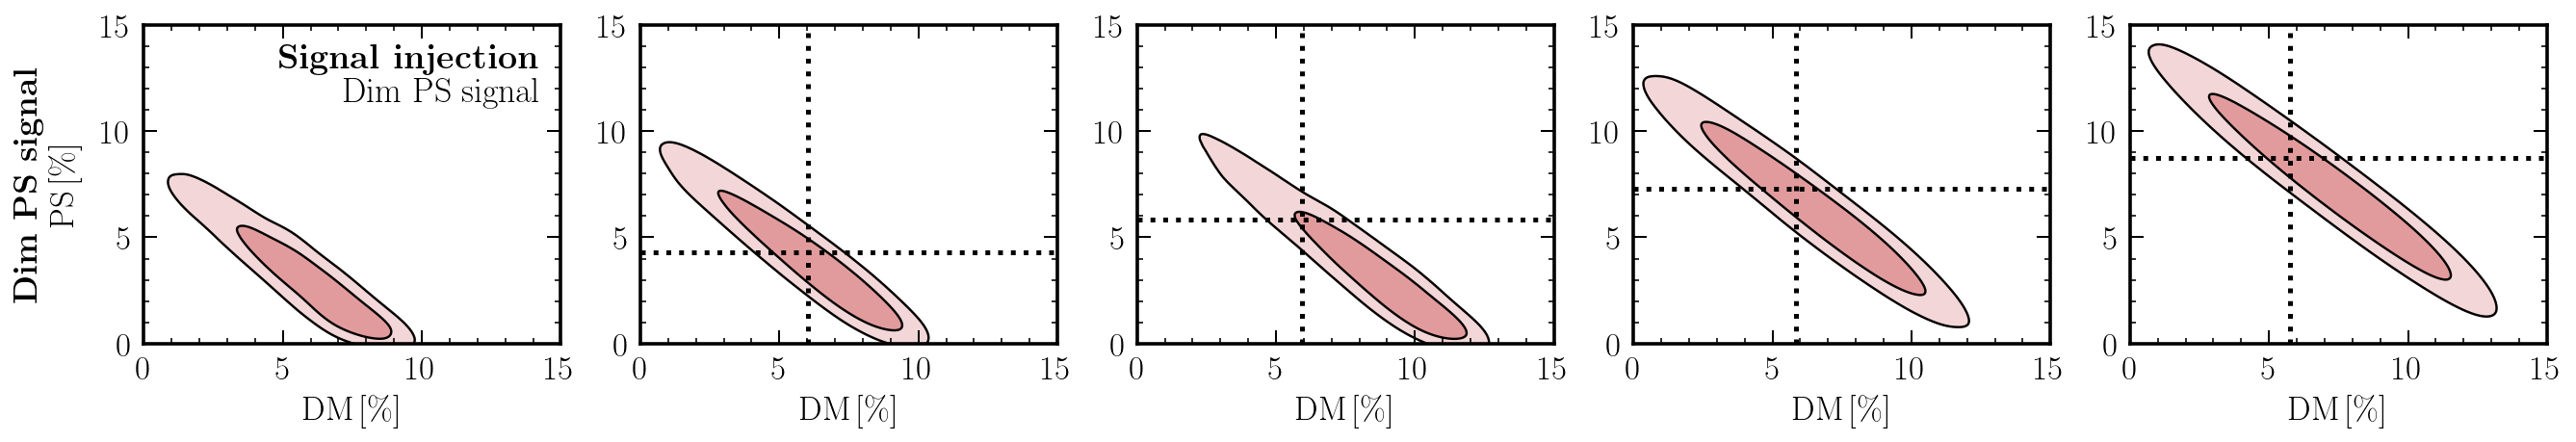

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [222]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection_ps(coeff, ps='dim').detach().numpy() for coeff in tqdm_notebook(coeff_ary)]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)
make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, signal_injection="ps", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_dim_ps.pdf", sub1=r"\bf{Signal injection}", sub2="Dim PS signal")

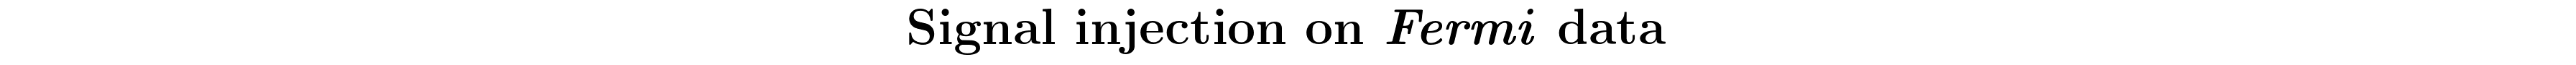

In [259]:
fig=plt.figure(figsize=(25,0.5))
ax=fig.add_subplot(1,1,1)
plt.text(0.5, 0.5,r'\bf{Signal injection on \emph{Fermi} data}',horizontalalignment='center',verticalalignment='center',transform = ax.transAxes, fontsize=35)
plt.axis('off')
plt.tight_layout()
plt.savefig("../paper/plots/sig_inj_title.pdf")

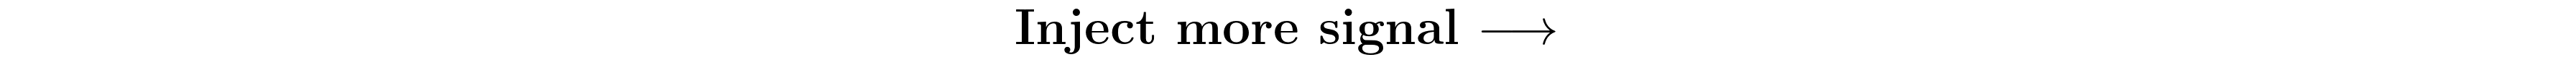

In [260]:
fig=plt.figure(figsize=(25,0.5))
ax=fig.add_subplot(1,1,1)
plt.text(0.5, 0.5,r'\bf{Inject more signal $\longrightarrow$}',horizontalalignment='center',verticalalignment='center',transform = ax.transAxes, fontsize=35)
plt.axis('off')
plt.tight_layout()
plt.savefig("../paper/plots/sig_inj_chyron.pdf")

### NPTF analysis on data

Removed no burn in
$7.7^{0.2}_{0.6}\%$ & $55.0^{8.8}_{22.9}\%$ & $2.3^{0.7}_{1.6}$ & $5.4^{0.5}_{1.1}\%$ & $3.5^{1.1}_{2.1}$


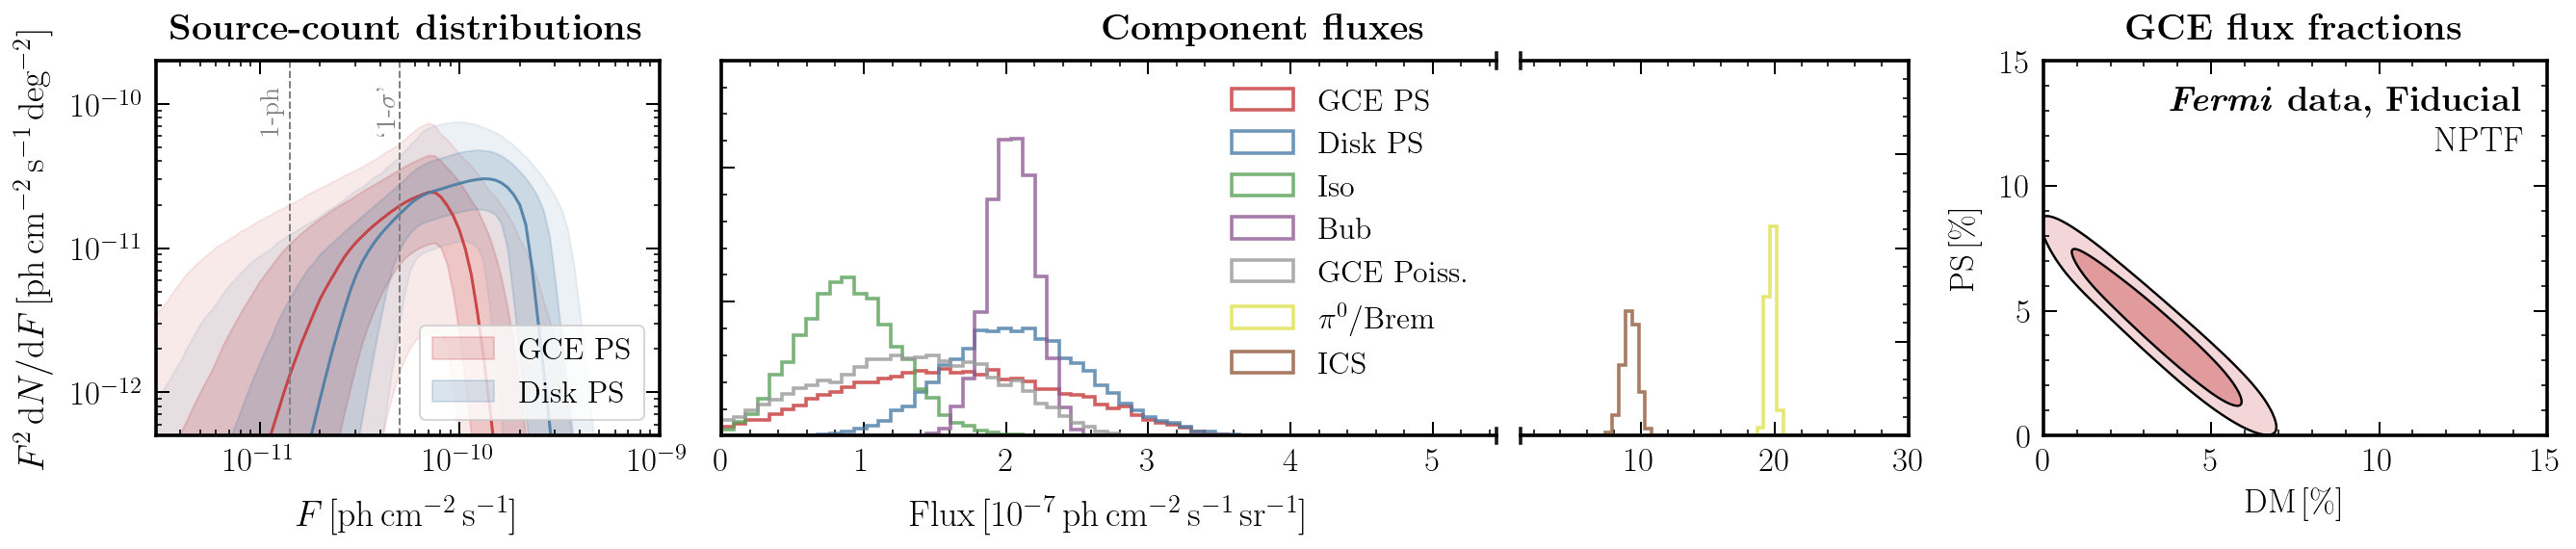

<Figure size 432x324 with 0 Axes>

In [206]:
coeff_ary = [0.]

samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_thin_disk_1000_-1_samples.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=None, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, figsize=(24 / 1.3, 5 / 1.3), nptf=True, save_filename="../paper/plots/data_fid_nptf.pdf", temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Fiducial}", sub2=r"NPTF")

## Original analysis

In [223]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce, temp_dsk]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$8.2^{0.2}_{0.6}\%$ & $13.4^{3.7}_{6.7}\%$ & $2.8^{1.2}_{2.7}$ & $5.2^{0.4}_{1.1}\%$ & $2.5^{1.3}_{2.1}$


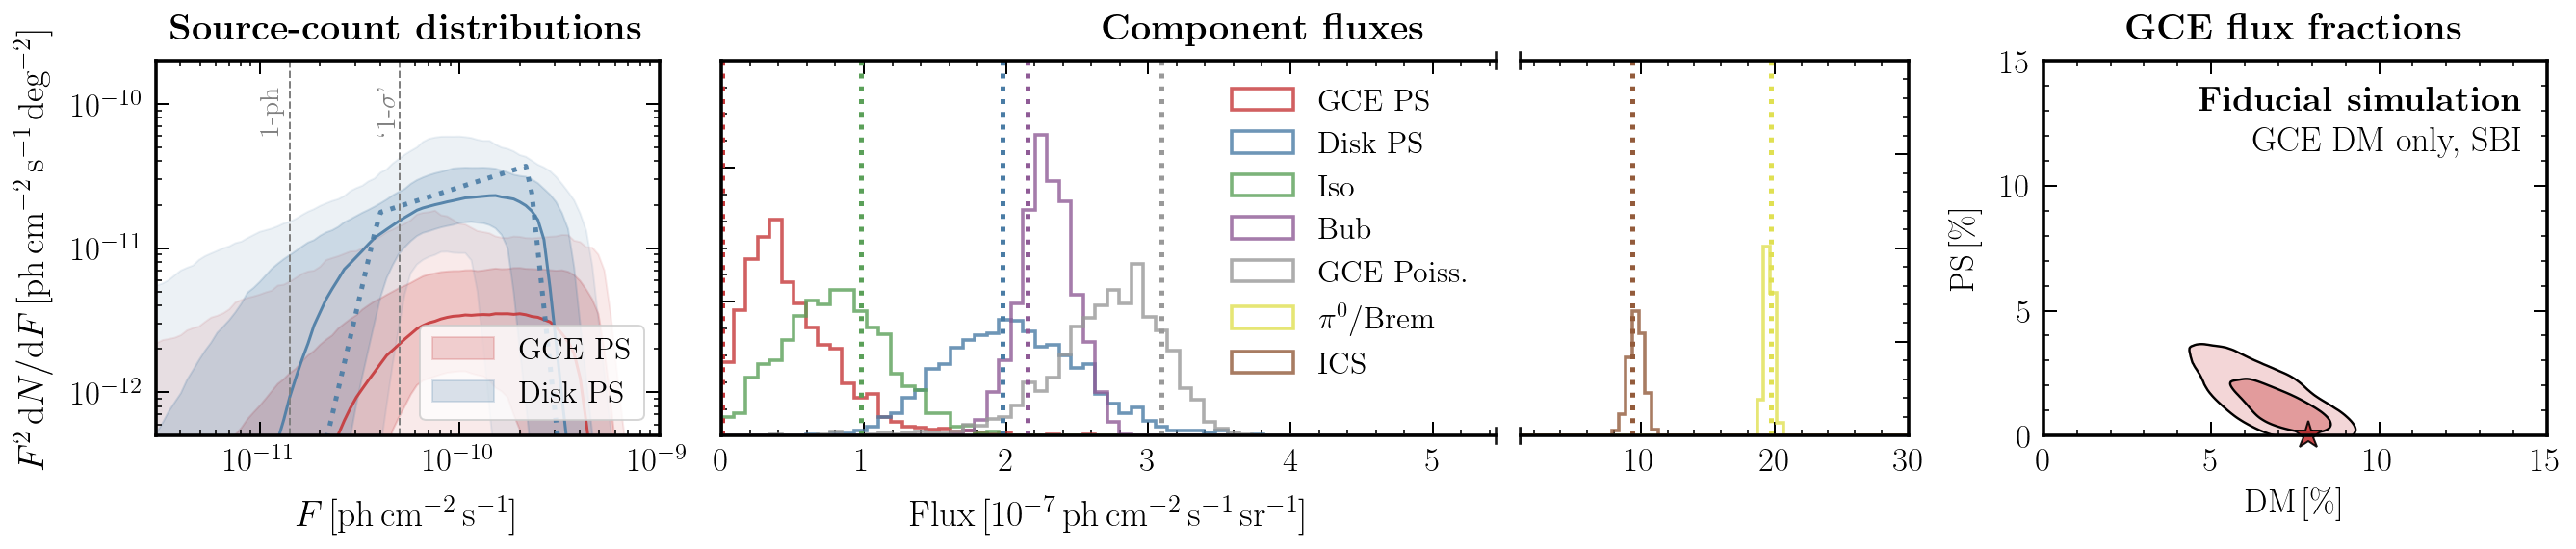

<Figure size 432x324 with 0 Axes>

In [228]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_only.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, 
          roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_dm_agg.pdf", sub1=r"\bf{Fiducial simulation}", sub2="GCE DM only, SBI", combined_posterior=True, thin_factor=1 / 5) 

### Mismodeling, Modulation

In [230]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce, temp_dsk]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$11.9^{0.2}_{0.6}\%$ & $6.0^{2.1}_{3.5}\%$ & $2.6^{1.1}_{2.5}$ & $7.3^{0.5}_{1.3}\%$ & $0.9^{0.9}_{0.8}$


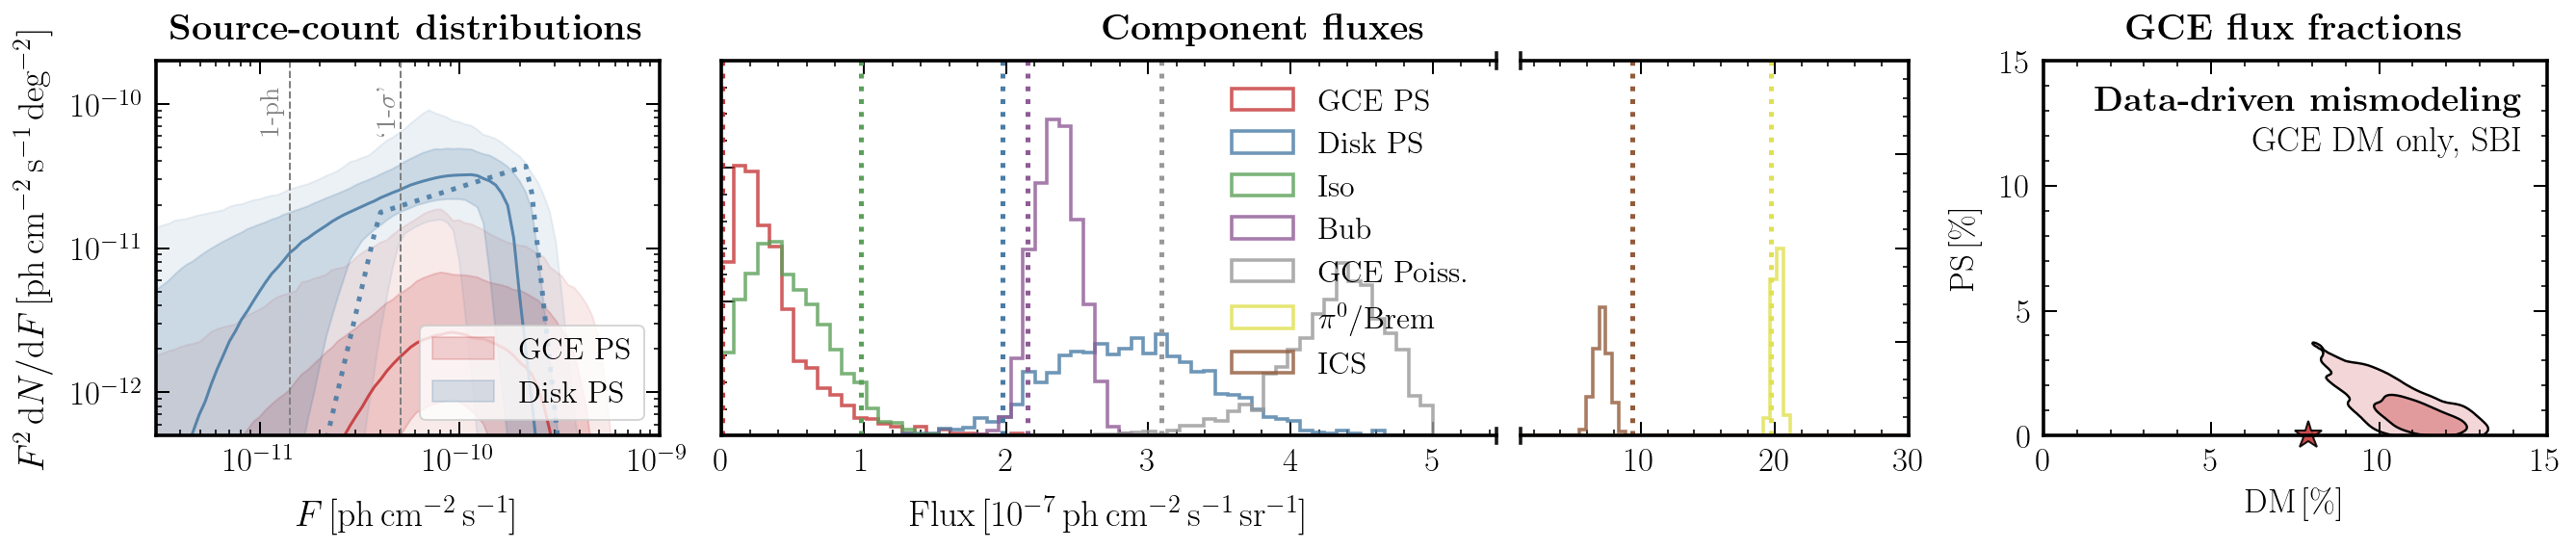

<Figure size 432x324 with 0 Axes>

In [231]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_only_mismo.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_only_mismo.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_DM_only_mismo.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, 
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_dm_mismo.pdf", sub1=r"\bf{Data-driven mismodeling}", sub2="GCE DM only, SBI", 
          combined_posterior=True, thin_factor=1 / 5) 

In [232]:
# data_map = ring2nest(np.load("../data/samples/x_ModelO_PS_only_mismo.npy")[:3, 0, :], roi_sim_ring)
# aux = np.load("../data/samples/x_aux_ModelO_PS_only_mismo.npy")[:3]
# thetas = np.load("../data/samples/theta_ModelO_PS_only_mismo.npy")[:3]

# x_presimulated = torch.Tensor(data_map).unsqueeze(1)
# x_aux_presimulated = torch.Tensor(aux)
# theta_presimulated = (thetas)

# inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
# posterior = inference_inst.build_posterior(prior, density_estimator)

# x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
# theta_test = theta_presimulated

# make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(25, 4), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_ps_mismo.pdf", sub1="Data-driven mismodeling, GCE PS only", sub2="Simulation-based inference", combined_posterior=True, thin_factor=1 / 3) 

## Asymmetric DM

In [255]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce, temp_dsk]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$11.2^{0.2}_{0.6}\%$ & $10.1^{3.3}_{6.0}\%$ & $2.6^{1.1}_{2.5}$ & $3.5^{0.4}_{0.9}\%$ & $3.7^{0.9}_{2.8}$


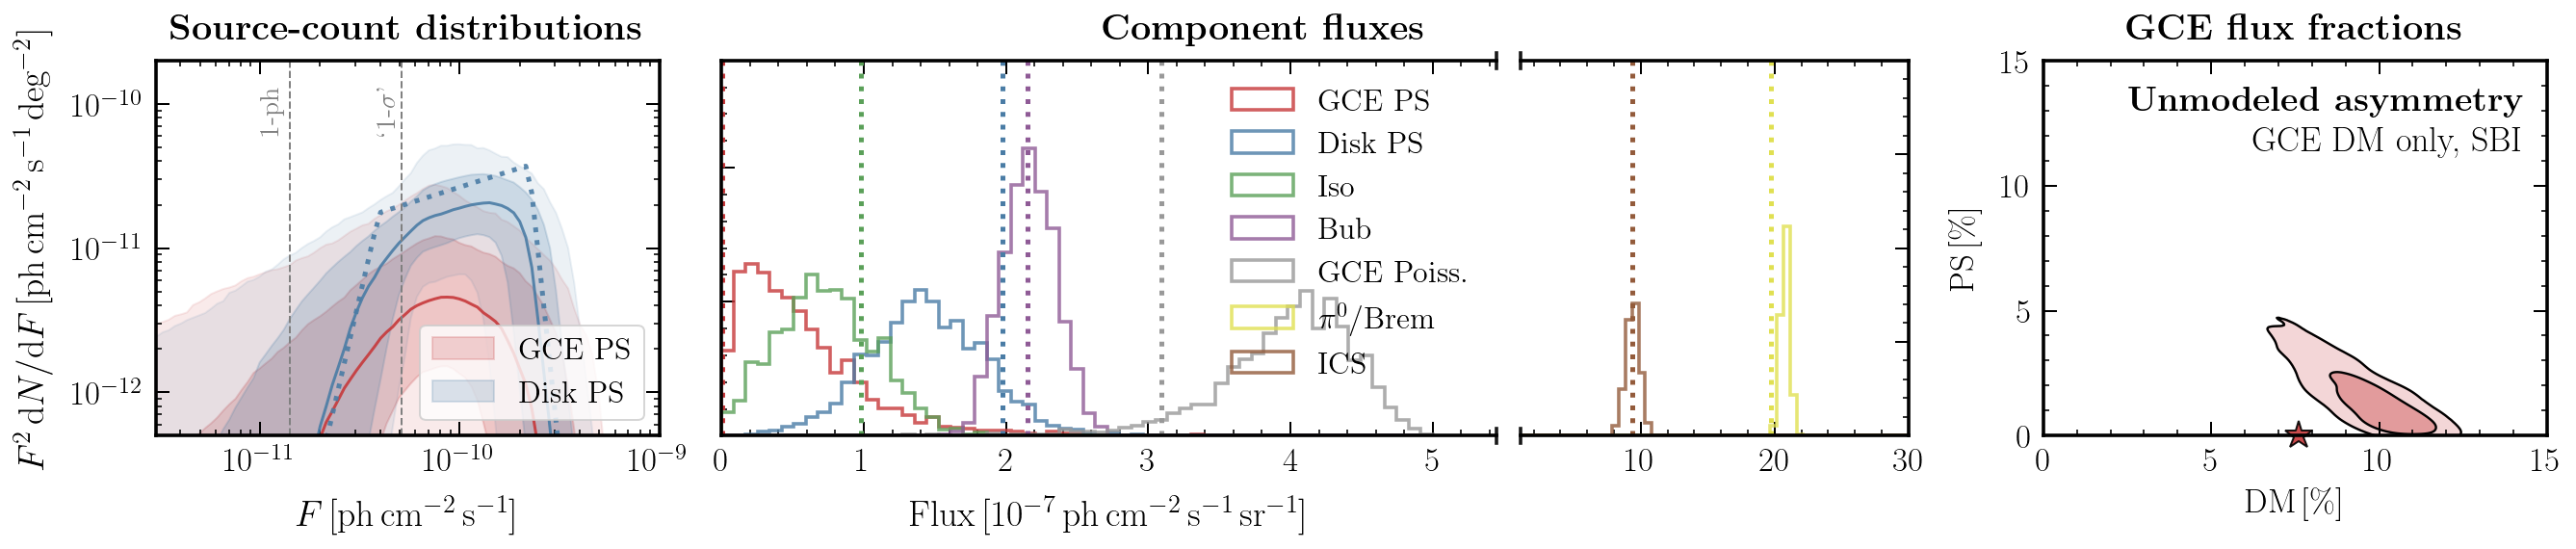

<Figure size 432x324 with 0 Axes>

In [256]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_asym.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_asym.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_DM_asym.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

theta_test_avg = 1.4 * torch.ones(theta_test.shape[0], theta_test.shape[1] - 1)
theta_test_avg[:, 1:] = torch.Tensor(theta_test[:, 2:])
theta_test_avg = theta_test_avg.detach().numpy()

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test_avg, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_dm_asym.pdf", sub1=r"\bf{Unmodeled asymmetry}", sub2="GCE DM only, SBI", 
          combined_posterior=True, thin_factor=1 / 5) 

## Model A

In [257]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce, temp_dsk]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$9.4^{0.2}_{0.6}\%$ & $14.0^{5.9}_{8.6}\%$ & $2.3^{1.0}_{2.2}$ & $6.7^{0.5}_{1.1}\%$ & $2.8^{0.9}_{2.3}$


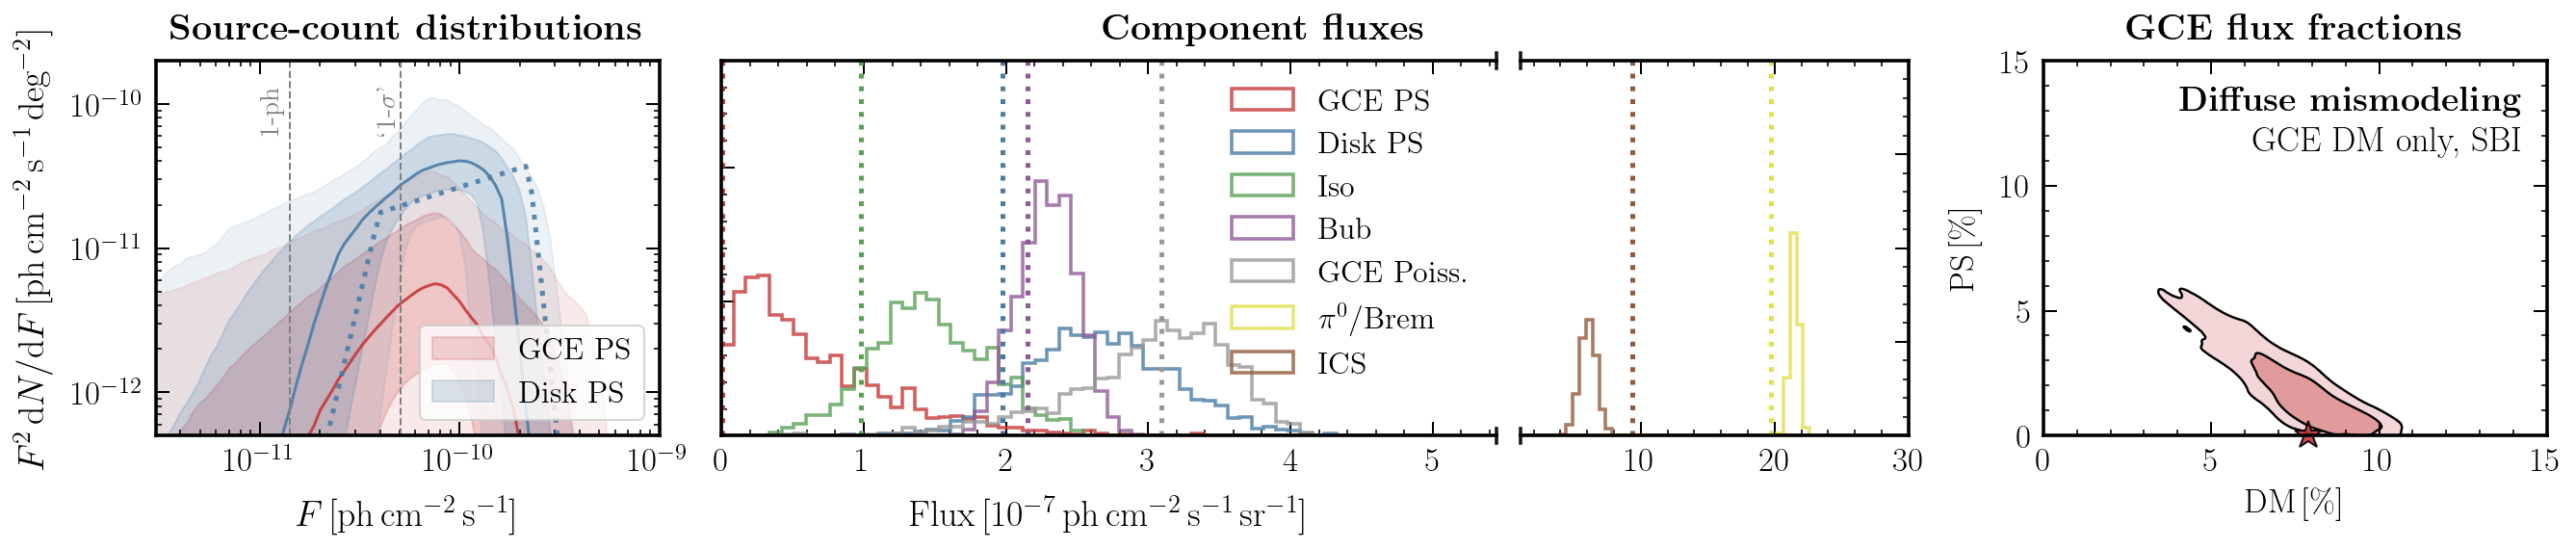

<Figure size 432x324 with 0 Axes>

In [258]:
data_map = ring2nest(np.load("../data/samples/x_ModelA_DM_only.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelA_DM_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelA_DM_only.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm,\
          figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_modelA_dm.pdf", sub1=r"\bf{Diffuse mismodeling}", sub2="GCE DM only, SBI", 
          combined_posterior=True, thin_factor=1 / 5) 

In [252]:
# data_map = ring2nest(np.load("../data/samples/x_ModelA_PS_only.npy")[:5, 0, :], roi_sim_ring)
# aux = np.load("../data/samples/x_aux_ModelA_PS_only.npy")[:5]
# thetas = np.load("../data/samples/theta_ModelA_PS_only.npy")[:5]

# x_presimulated = torch.Tensor(data_map).unsqueeze(1)
# x_aux_presimulated = torch.Tensor(aux)
# theta_presimulated = (thetas)

# inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
# posterior = inference_inst.build_posterior(prior, density_estimator)

# x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
# theta_test = theta_presimulated

# make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(25, 4), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_modelA_ps.pdf", sub1="Simulation, Diffuse mismodeling", sub2="Simulation-based inference", combined_posterior=True, thin_factor=1 / 5) 

## Thick disk

In [253]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce, temp_dsk]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
$8.2^{0.2}_{0.6}\%$ & $34.6^{6.7}_{14.0}\%$ & $2.6^{1.1}_{2.5}$ & $2.5^{0.4}_{0.8}\%$ & $4.0^{0.9}_{2.8}$


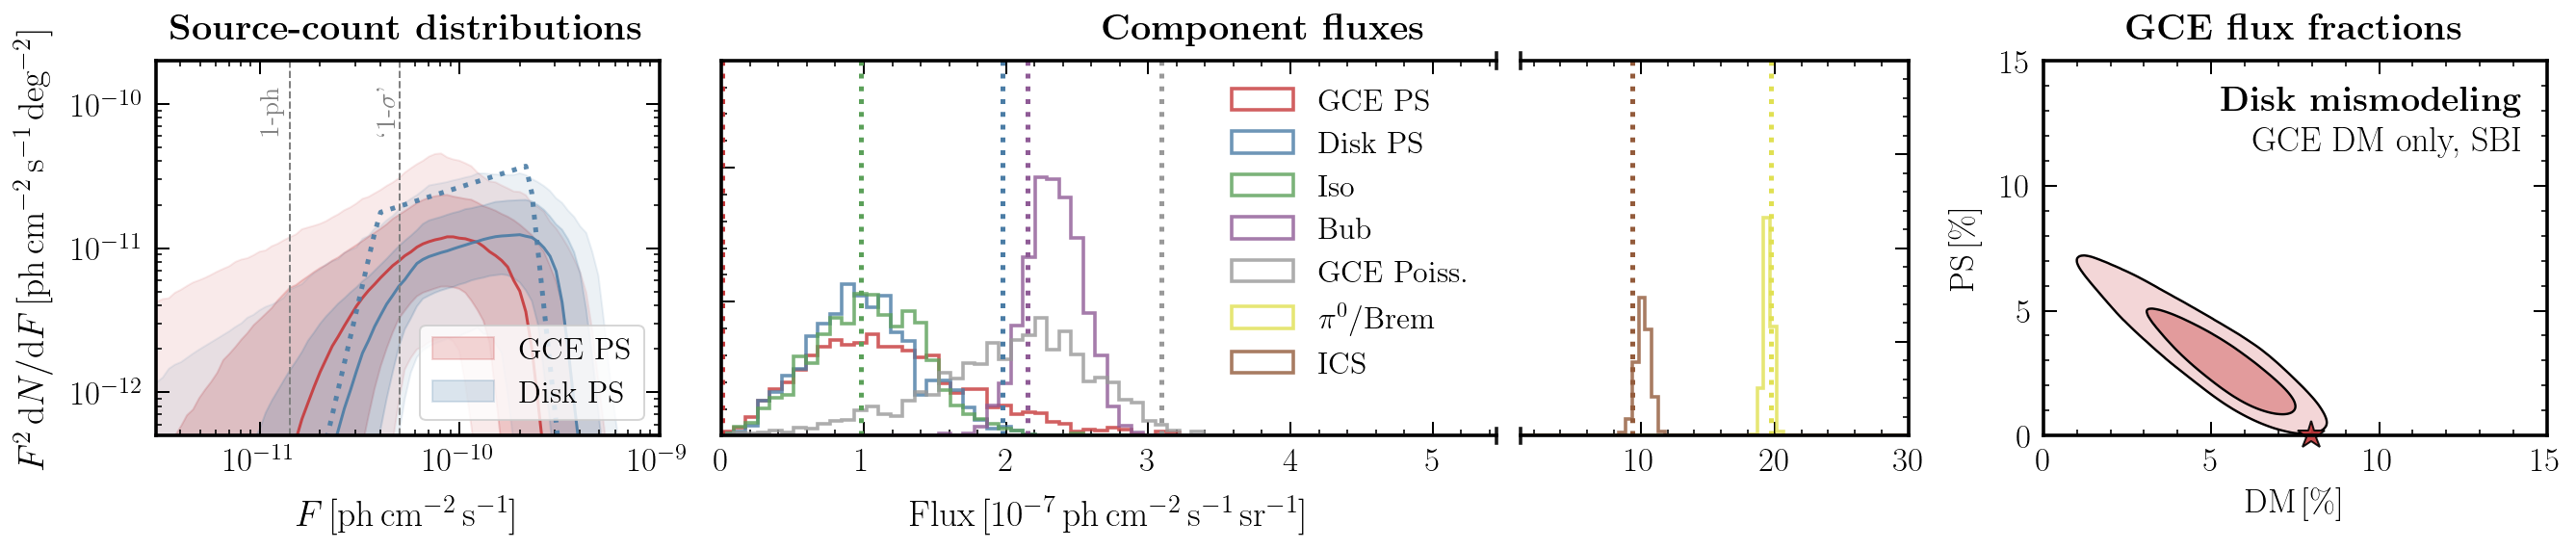

<Figure size 432x324 with 0 Axes>

In [254]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_thick_disk_DM_only.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_thick_disk_DM_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_thick_disk_DM_only.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, 
          figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_thick_disk_mm_dm.pdf", 
          sub1=r"\bf{Disk mismodeling}", sub2="GCE DM only, SBI", combined_posterior=True, thin_factor=1 / 5) 